# Discovery test example

pip install optree zfit asdf

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import zfit
from utils import plotfitresult, pltdist, plotasimov
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit

import os
os.chdir("/home/cms-jovyan/hepstats/hepstats/src")

# from hepstats.hypotests import Discovery
from hepstats.hypotests.calculators import AsymptoticCalculator
# from hepstats.hypotests.parameters import POI, ParameterValue
from hepstats.hypotests import discovery
from hepstats.utils import minimizers, api

os.chdir("/home/cms-jovyan/hepstats/hepstats/notebooks/hypotests")
print(os.listdir())

/usr/local/lib/python3.12/site-packages/zfit/__init__.py:68: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


['confidenceinterval_asy_zfit.ipynb', 'FC_interval_freq.ipynb', 'asy_ci.png', '__pycache__', '.ipynb_checkpoints', 'counting.ipynb', 'asy_ul.png', 'confidenceinterval_freq_zfit.ipynb', 'upperlimit_asy_zfit.ipynb', 'FC_interval_asy.ipynb', 'discovery_freq_zfit.ipynb', 'example_notebook.ipynb', '__init__.py', 'testbed.ipynb', 'discovery_asy_zfit.ipynb', 'toys', 'Simultaneous_fit_discovery_splot.ipynb', 'utils.py', 'upperlimit_freq_zfit.ipynb']


In [2]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 16

### Fit of a Gaussian signal over an exponential background:

In [3]:
bounds = (0.1, 3.0)

# Data and signal
stat_multiplier = 2

np.random.seed(0)
tau = -2.0
beta = -1 / tau
data = np.random.exponential(beta, 300 * stat_multiplier)
peak = np.random.normal(1.2, 0.1, 25 * stat_multiplier)
data = np.concatenate((data, peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

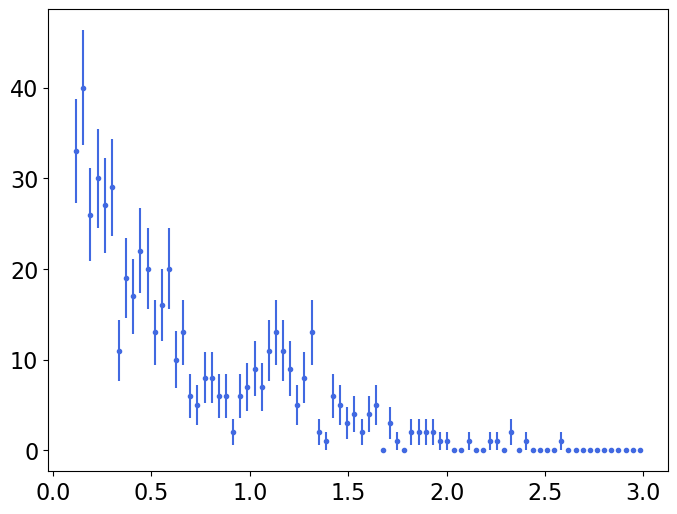

In [4]:
pltdist(data, bins=80, bounds=bounds)

In [5]:
obs = zfit.Space("x", limits=bounds)

In [6]:
zfit_lambda = zfit.Parameter("lambda", -2.0, -4.0, -1.0)
zfit_Nsig = zfit.Parameter("Nsig", 20.0, -20.0, len(data))
zfit_Nbkg = zfit.Parameter("Nbkg", len(data), 0.0, len(data) * 1.1)

signal = zfit.pdf.Gauss(obs=obs, mu=1.2, sigma=0.1).create_extended(zfit_Nsig)
background = zfit.pdf.Exponential(obs=obs, lambda_=zfit_lambda).create_extended(zfit_Nbkg)
tot_model = zfit.pdf.SumPDF([signal, background])



In [7]:
# Create the negative log likelihood
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
zfit_nll = ExtendedUnbinnedNLL(model=[tot_model], data=[data_])

In [8]:
class ParamWrapper:
    def __init__(self, zfit_param):
        self.value = float(zfit_param.value())
        self.floating = zfit_param.floating
        self.upper = float(zfit_param.upper)
        self.lower = float(zfit_param.lower)

Nsig = ParamWrapper(zfit_Nsig)
Nbkg = ParamWrapper(zfit_Nbkg)
lambda_ = ParamWrapper(zfit_lambda)

from typing import NamedTuple
class CustomParameter(NamedTuple):
    value : ArrayLike
    floating : ArrayLike
    upper : ArrayLike
    lower : ArrayLike
    
bkg = CustomParameter(
    value = np.array([Nbkg.value, lambda_.value]),
    floating = True,
    upper = np.array([Nbkg.upper, lambda_.upper]),
    lower = np.array([Nbkg.lower, lambda_.lower])
)

class LossWrapper:
    def __init__(self, zfit_loss):
        self.zfit_loss = zfit_loss

    def __call__(self, params):
        # return self.zfit_loss([params["Nsig"], params["Nbkg"], params["lambda"]])
        return self.zfit_loss([params["signal"], params["background"][0], params["background"][1]])

nll = LossWrapper(zfit_nll)

In [9]:
# params = {"Nsig" : Nsig, "Nbkg" : Nbkg, "lambda" : lambda_}
params = {"signal" : Nsig, "background" : bkg}

Instantiate zfit minimizer and fit with all parameters floating

In [10]:
if False:
    Nsig.value = 0
    Nsig.floating = False

In [11]:
# nll.get_param_specs()


zfit_minimizer = minimizers.IMinuit()
zfit_minimum = zfit_minimizer.minimize(nll, params)
zfit_minimum

Minimum(valid=True, fmin=209.02275895944683, params={'signal': 45.85296920687642, 'background': [493.14606107775796, -1.940309616426445]})

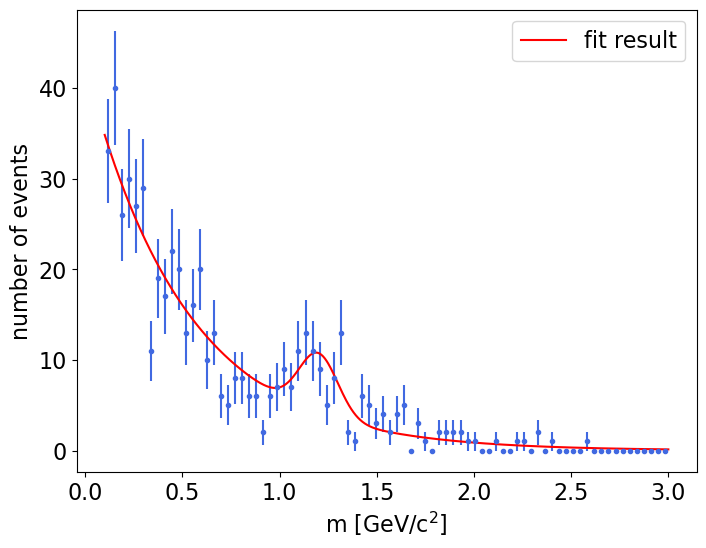

In [12]:
min_values = zfit_minimum.params

# for param, v in zip(zfit_nll.get_params(), [min_values["Nsig"], min_values["Nbkg"], min_values["lambda"]]):
#     param.set_value(v)

for param, v in zip(zfit_nll.get_params(), [min_values["signal"], min_values["background"][0], min_values["background"][1]]):
    param.set_value(v)

nbins = 80
pltdist(data, nbins, bounds)
plotfitresult(tot_model, bounds, nbins)
# plotasimov(tot_model, bounds, nbins)
# signal = zfit.pdf.Gauss(obs=obs, mu=1.2, sigma=0.1).create_extended(Nsig)
# background = zfit.pdf.Exponential(obs=obs, lambda_=lambda_).create_extended(Nbkg)
# tot_model = zfit.pdf.SumPDF([signal, background])

# bin_width = (bounds[1] - bounds[0]) / nbins
# tot_model_func = lambda x, Nsig, Nbkg, lamb: (Nsig / (0.1 * np.sqrt(2 * np.pi))) * np.exp(-(x - 1.2)**2 / (2 * 0.1**2)) - Nbkg * lamb * np.exp(lamb * x)
# xsample = np.linspace(*bounds, 100)

# plotting_params = [x["value"] for x in minimum.params.values()]
# zfit_plotting_params = [x["value"] for x in zfit_minimum.params.values()]
# plt.plot(xsample, tot_model_func(xsample, *plotting_params) * bin_width, color="orange", label="scipy backend")
# plt.plot(xsample, tot_model_func(xsample, *zfit_minimum.param_values) * bin_width, color="red", label="zfit backend")

plt.xlabel("m [GeV/c$^2$]")
plt.ylabel("number of events")
plt.legend()

### Discovery test

In a discovery test the null hypothesis is the absence of signal, .i.e Nsig = 0.

In [13]:
# instantation of the calculator
# calculator = AsymptoticCalculator(my_nll, minimizer)

In [14]:
calculator = AsymptoticCalculator(nll, params)
pnull, significance = discovery(calculator, "signal")
significance

nll_poinull_obs=[222.87373389], nll_bestfitpoi_obs=[209.02277034]
poinull=POI(''signal'', value=0), bestfitpoi=POI(''signal'', value=45.85296920687642)
pnull = [7.07608296e-08], qobs = [27.7019271]


5.263262020546467

## Comparison Cells

In [ ]:
# parameter of interest of the null hypothesis
# my_Nsig = my_nll.get_params()[0]
# poinull = POI(my_Nsig, 0)
zfit_poinull = POI(Nsig, 0)

In [ ]:
# instantation of the discovery test
# discovery_test = Discovery(calculator, poinull)
zfit_discovery_test = Discovery(zfit_calculator, zfit_poinull)

In [ ]:
# pnull, significance = discovery_test.result()
zfit_pnull, zfit_significance = zfit_discovery_test.result()

In [ ]:
zfit_significance